In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from ramannoodles import spectrafit
from ramannoodles import shoyu
from scipy import interpolate
import pandas as pd
import math

In [3]:
#If you re-call the method, it will tell you that the files are already downloaded.
shoyu.initialize_standard_library()
# open spectra library
shoyu_data_dict = pickle.load(open('../raman_spectra/shoyu_data_dict.p', 'rb'))
# list keys
sorted(shoyu_data_dict.keys())

file already in raman_spectra folder
WATER loaded into the dictionary - shoyu_data_dict.p
file already in raman_spectra folder
CARBON MONOXIDE loaded into the dictionary - shoyu_data_dict.p
file already in raman_spectra folder
CARBON DIOXIDE loaded into the dictionary - shoyu_data_dict.p
file already in raman_spectra folder
FORMIC ACID loaded into the dictionary - shoyu_data_dict.p
file already in raman_spectra folder
2-PROPANOL loaded into the dictionary - shoyu_data_dict.p
file already in raman_spectra folder
ETHYL ALCOHOL loaded into the dictionary - shoyu_data_dict.p
file already in raman_spectra folder
DIMETHYL KETONE loaded into the dictionary - shoyu_data_dict.p


['2-PROPANOL',
 'CARBON DIOXIDE',
 'CARBON MONOXIDE',
 'DIMETHYL KETONE',
 'ETHYL ALCOHOL',
 'FORMIC ACID',
 'WATER']

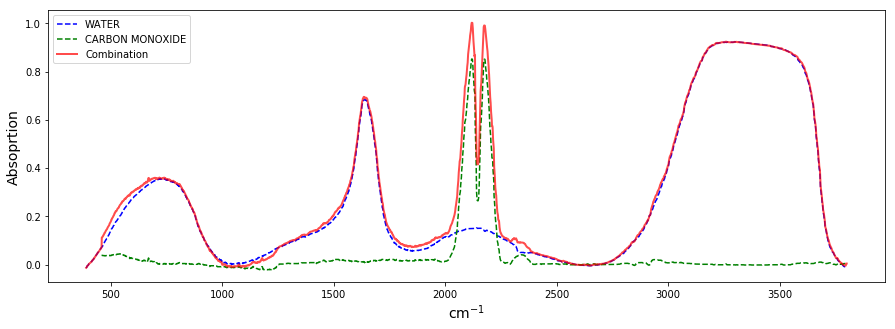

In [4]:
compound_1 = shoyu_data_dict['WATER']
compound_2 = shoyu_data_dict['CARBON MONOXIDE']
spectra_x, spectra_y = shoyu.combine_spectra(compound_1, compound_2, plot = True)

In [5]:
# Exploring a basic example from lmfit documentation
import lmfit
import numpy as np
x = np.linspace(0.3, 10, 100)
np.random.seed(0)
y = 1/(0.1*x) + 2 + 0.1*np.random.randn(x.size)
pars = lmfit.Parameters()
pars.add_many(('a', 0.1), ('b', 1))
def residual(p):
    return 1/(p['a']*x) + p['b'] - y

In [6]:
# Running a fit 
mini = lmfit.Minimizer(residual,pars)
result = mini.minimize()
print(mini.leastsq())
print(lmfit.fit_report(result.params))

[[Variables]]
    a:  0.09943896 +/- 1.9322e-04 (0.19%) (init = 0.1)
    b:  1.98476945 +/- 0.01222678 (0.62%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, b) =  0.601


In [7]:
# Getting a basic confidence interval
ci = lmfit.conf_interval(mini,result)
lmfit.printfuncs.report_ci(ci)

      99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a:  -0.00059  -0.00039  -0.00019   0.09944  +0.00019  +0.00039  +0.00060
 b:  -0.03766  -0.02478  -0.01230   1.98477  +0.01230  +0.02478  +0.03761


In [8]:
# using quantiles got the sigmas and using the trace

In [9]:
#Bootstrapping is also an option

In [10]:
#function calculates distance start
def peak_1D_score(rowA,rowB,scoremax):
    """
    Returns scores with respect to the repricoal of the 
    calculated Euclidean distance between peaks
    #√((x1-x2)^2) in 1D
    #√((x1-x2)^2 + (y1-y2)^2) in 2D

    Parameters:
        list_input (list):  input list
        row (list): input list
        scoremax (float): Euclidean reciprocal score divided by max score

    Returns:
        scores (list): Euclidean reciprocal scores
        peaks (tuple): peaks associated with scores
    """
    scores = []
    peaks=[]
    

    for i in range(len(rowA)):
        for j in range(len(rowB)):
            distance = np.where((rowA[i] - rowB[j]>50),np.nan,math.sqrt(sum([math.pow(rowA[i] - rowB[j], 2)])))
            if (1/(distance + 1)>.02): # Score for peaks less than 50 units apart
                scores.append((((1/(distance + 1))/scoremax)))
                peaks.append((rowA[i],rowB[j]))
            else:
                pass
    return scores,peaks
def score_max(list_input, row,k):
    """
    Returns list of scores with respect to its output max score

    Parameters:
        list_input (list):  input list
        row (list): input list
        k (int): input integer used to sort the scores / kth highest score

    Returns:
        maxscores (list): Euclidean reciprocal score divided by max score
        maxpeaks (tuple): peaks associated with max scores
    """
    try:
        maxscores,maxpeaks = peak_1D_score(list_input,row,sorted(set(peak_1D_score(list_input,row,1)[0][:]))[-k])
    
    except Exception as e:
        
        maxscores,maxpeaks = peak_1D_score(row, list_input,scoremax=1)
        
    return maxscores,maxpeaks
def score_sort(list_input, row,k):
    """
    Returns list of scores sorted

    Parameters:
        list_input (list):  input list
        row (list): input list
        k (int): input integer used to sort the scores / kth highest score

    Returns:
        sortedscores (list): sorted Euclidean distances
    """
    sortedscores = []
    sortedscores.append(score_max(list_input,row,k))
    sortedscores.sort()
    return sortedscores

In [11]:
compound_1 = shoyu_data_dict['WATER']
x_water = compound_1['x']
y_water = compound_1['y']
compound_2 = shoyu_data_dict['CARBON MONOXIDE']
x_co = compound_1['x']
y_co = compound_1['y']
compound_3 = shoyu_data_dict['CARBON DIOXIDE']
x_co2 = compound_1['x']
y_co2 = compound_1['y']
peaks_centers1 = spectrafit.compound_report(compound_1)
print(peaks_centers1)
peaks_centers2 = spectrafit.compound_report(compound_2) 
peaks_centers3 = spectrafit.compound_report(compound_3) 
centerlist= [peaks_centers1,peaks_centers2,peaks_centers3]

([711.4826030832157, 1638.6886199554203, 3312.1231809302135], [137.39537530175036, 61.11779722916691, 264.75269111858455], [162.25486499090357, 125.0854818402531, 872.9935285452162], 388.677, 3799.46)


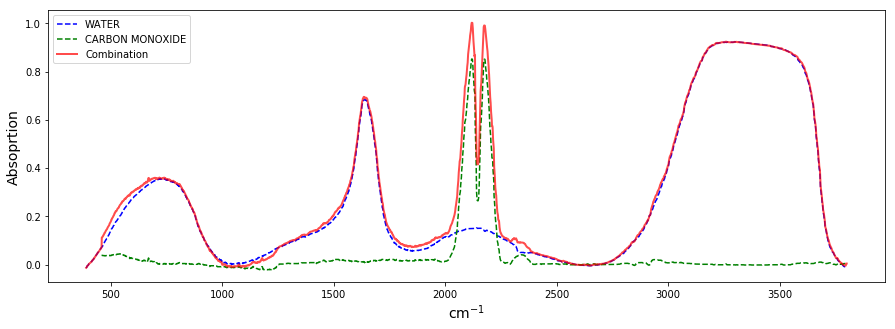

In [12]:
combined_x12,combined_y12 = shoyu.combine_spectra(compound_1,compound_2, plot = True)

In [13]:
data_peaks_combine12 = spectrafit.data_report(combined_x12,combined_y12)
peak_1D_score(peaks_centers1,data_peaks_combine12,sorted(set(peak_1D_score(peaks_centers1,data_peaks_combine12,1)[0][:]))[-2])

TypeError: unsupported operand type(s) for -: 'list' and 'list'

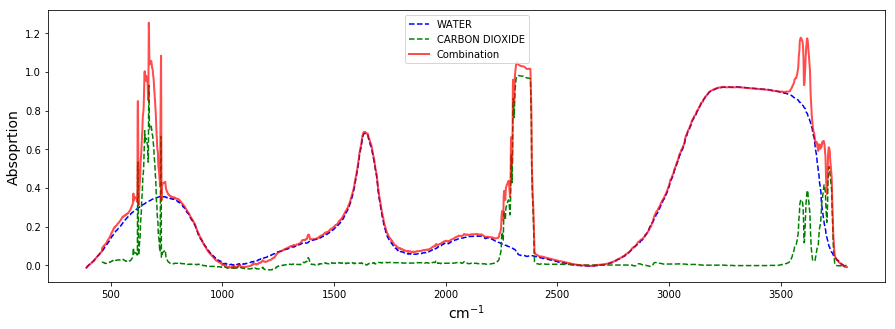

In [14]:
combined_x13,combined_y13  = shoyu.combine_spectra(compound_1, compound_3, plot = True)

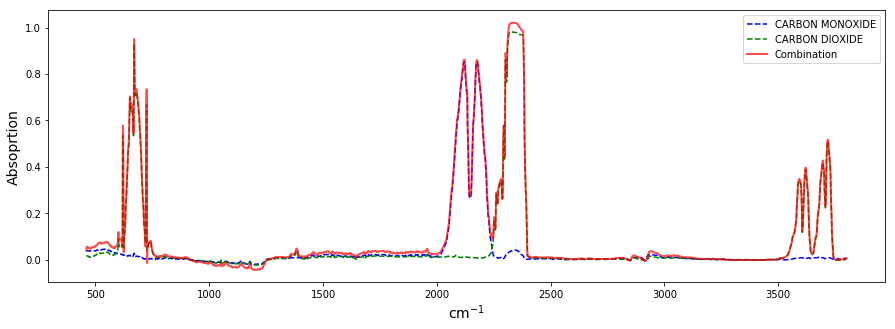

In [15]:
combined_x23,combined_y23  = shoyu.combine_spectra(compound_2, compound_3, plot = True)

In [16]:
data_peaks_combine12 = spectrafit.data_report(combined_x12,combined_y12)


In [17]:
data_peaks_combine13 = spectrafit.data_report(combined_x13,combined_y13)


In [18]:
data_peaks_combine23 = spectrafit.data_report(combined_x23,combined_y23)


In [19]:
combinedlist=[data_peaks_combine12,data_peaks_combine13,data_peaks_combine23]

In [20]:
print(peaks_centers1)
print(data_peaks_combine12)
print(peaks_centers2)
print(combinedlist)
print(centerlist)
compdf = pd.DataFrame(data=score_sort(data_peaks_combine12,peaks_centers1,2)[0][0][:],columns=['WATER_vs_CO_WATER_Scores'])
compdf=compdf.assign(WATER_vs_CO_WATER_Peaks=score_sort(data_peaks_combine12,peaks_centers1,2)[0][1][:])
compdf2=pd.DataFrame(data=score_sort(data_peaks_combine12,peaks_centers2,2)[0][0][:],columns=['CO_vs_CO_WATER_Scores'])
compdf2=compdf2.assign(CO_vs_CO_WATER_scores=score_sort(data_peaks_combine12,peaks_centers2,2)[0][1][:])
# data=score_sort(data_peaks_combine13,peaks_centers1)
# print(data)
print(compdf)
print(compdf2)

([711.4826030832157, 1638.6886199554203, 3312.1231809302135], [137.39537530175036, 61.11779722916691, 264.75269111858455], [162.25486499090357, 125.0854818402531, 872.9935285452162], 388.677, 3799.46)
([708.0, 1638.5198632531205, 2110.0000000000095, 2184.149153919652, 3268.999999970273], [139.83033669023976, 60.961055076687835, 29.158069800423903, 21.50620007219589, 265.20281991704775], [170.38584511373327, 126.94038930286825, 79.65940189444206, 56.3882637636494, 858.1037539938558], 390, 3801)
([2109.8548231081886, 2183.58416497579], [26.84556967062682, 21.03576890368042], [66.74326658230372, 51.6566695320977], 457.865, 3803.38)
[([708.0, 1638.5198632531205, 2110.0000000000095, 2184.149153919652, 3268.999999970273], [139.83033669023976, 60.961055076687835, 29.158069800423903, 21.50620007219589, 265.20281991704775], [170.38584511373327, 126.94038930286825, 79.65940189444206, 56.3882637636494, 858.1037539938558], 390, 3801), ([611.000000000001, 652.0861593999174, 679.999999892973, 734.99

TypeError: unsupported operand type(s) for -: 'list' and 'list'

In [21]:
k_range = range(1,len(data_peaks_combine12))
for k in k_range:
    compdf = pd.DataFrame(data=score_sort(data_peaks_combine12,peaks_centers1,k)[0][0][:],columns=['Score for max peak #'+str(k)])
    compdf=compdf.assign(peaks=score_sort(data_peaks_combine12,peaks_centers1,k)[0][1][:])
    print(compdf)

TypeError: unsupported operand type(s) for -: 'list' and 'list'

In [22]:
k_range = range(1,len(data_peaks_combine23))
for i in range(len(combinedlist)):
    for j in range(len(centerlist)):
        for k in k_range:
            compdf = pd.DataFrame(data=score_sort(centerlist[j],combinedlist[i],k)[0][0][:],columns=['Score for max peak k#'+str(k)])
            compdf=compdf.assign(peaks=score_sort(centerlist[j],combinedlist[i],k)[0][1][:])
            print(compdf)

TypeError: unsupported operand type(s) for -: 'list' and 'list'

In [23]:
data=score_sort(centerlist[0],combinedlist[1],1)
print(data)

TypeError: unsupported operand type(s) for -: 'list' and 'list'

In [24]:
scores=score_sort(centerlist[0],combinedlist[0],1)[0][0][:]
peaks=score_sort(centerlist[0],combinedlist[0],1)[0][1][:]
print(peaks)
compdf = pd.DataFrame(data=scores,columns=['WATER_comp_CO_Scores'])
compdf=compdf.assign(WATER__comp_CO_Peaks=peaks)
scores=score_sort(centerlist[0],combinedlist[0],1)[0][0][:]
peaks=score_sort(centerlist[0],combinedlist[0],1)[0][1][:]
print(peaks)
compdf=compdf.assign(Peaks=peaks)
print(compdf)

TypeError: unsupported operand type(s) for -: 'list' and 'list'

In [25]:
compdf = pd.DataFrame(data=scores,columns=['WATER_comp_CO_Scores'])

NameError: name 'scores' is not defined

In [26]:
# you will need to download the file yourself from the team google drive and edit location
df = pd.read_excel('../examples/FormicAcid_3percentconc_400C_5s_00000.xlsx', names=('x', 'y'))

In [27]:
fig = plt.figure(figsize=(6,4), dpi = 300)
x_data = df['x'].values
y_data = df['y'].values

<Figure size 1800x1200 with 0 Axes>

In [28]:
# Exp_peaks = spectrafit.data_report(x_data, y_data)

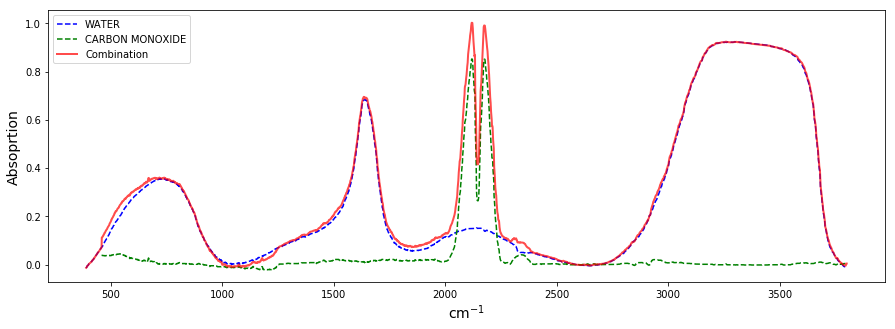

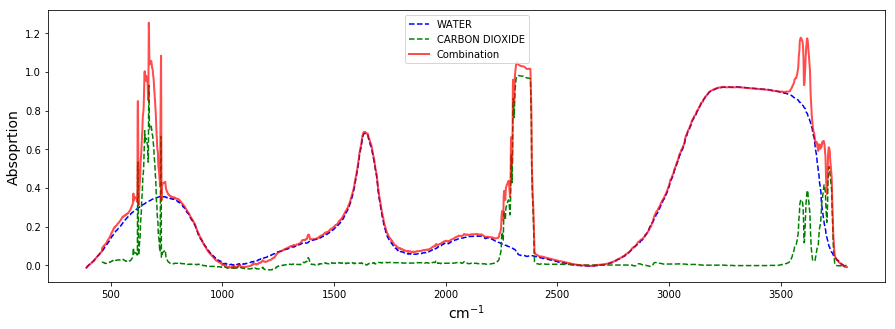

In [29]:
compound_1 = shoyu_data_dict['WATER']
compound_2 = shoyu_data_dict['CARBON MONOXIDE']
compound_3 = shoyu_data_dict['ETHYL ALCOHOL']
compound_4 = shoyu_data_dict['FORMIC ACID']
compound_5 = shoyu_data_dict['CARBON DIOXIDE']
H2O_CO_x, H2O_CO_y = shoyu.combine_spectra(compound_1, compound_2, plot = True)
H2O_CO2_x, H2O_CO2_y = shoyu.combine_spectra(compound_1, compound_5, plot = True)

In [30]:
H2O_CO_x = np.asarray(H2O_CO_x)
H2O_CO_y = np.asarray(H2O_CO_y)
H2O_CO2_x = np.asarray(H2O_CO2_x)
H2O_CO2_y = np.asarray(H2O_CO2_y)

In [31]:
water_peaks = spectrafit.compound_report(compound_1)[0]
co_peaks = spectrafit.compound_report(compound_2)[0]
co2_peaks = spectrafit.compound_report(compound_5)[0]
H2O_CO_peaks = spectrafit.data_report(H2O_CO_x, H2O_CO_y)
print(H2O_CO_peaks)
H2O_CO2_peaks = spectrafit.data_report(H2O_CO2_x, H2O_CO2_y)


KeyboardInterrupt: 

In [32]:
print(H2O_CO2_peaks)

NameError: name 'H2O_CO2_peaks' is not defined

In [33]:
Exp_peaks = [355,379,418,587,712,751,814,1034,1219,1272,1383,1400,1640,2138,2943,3185]

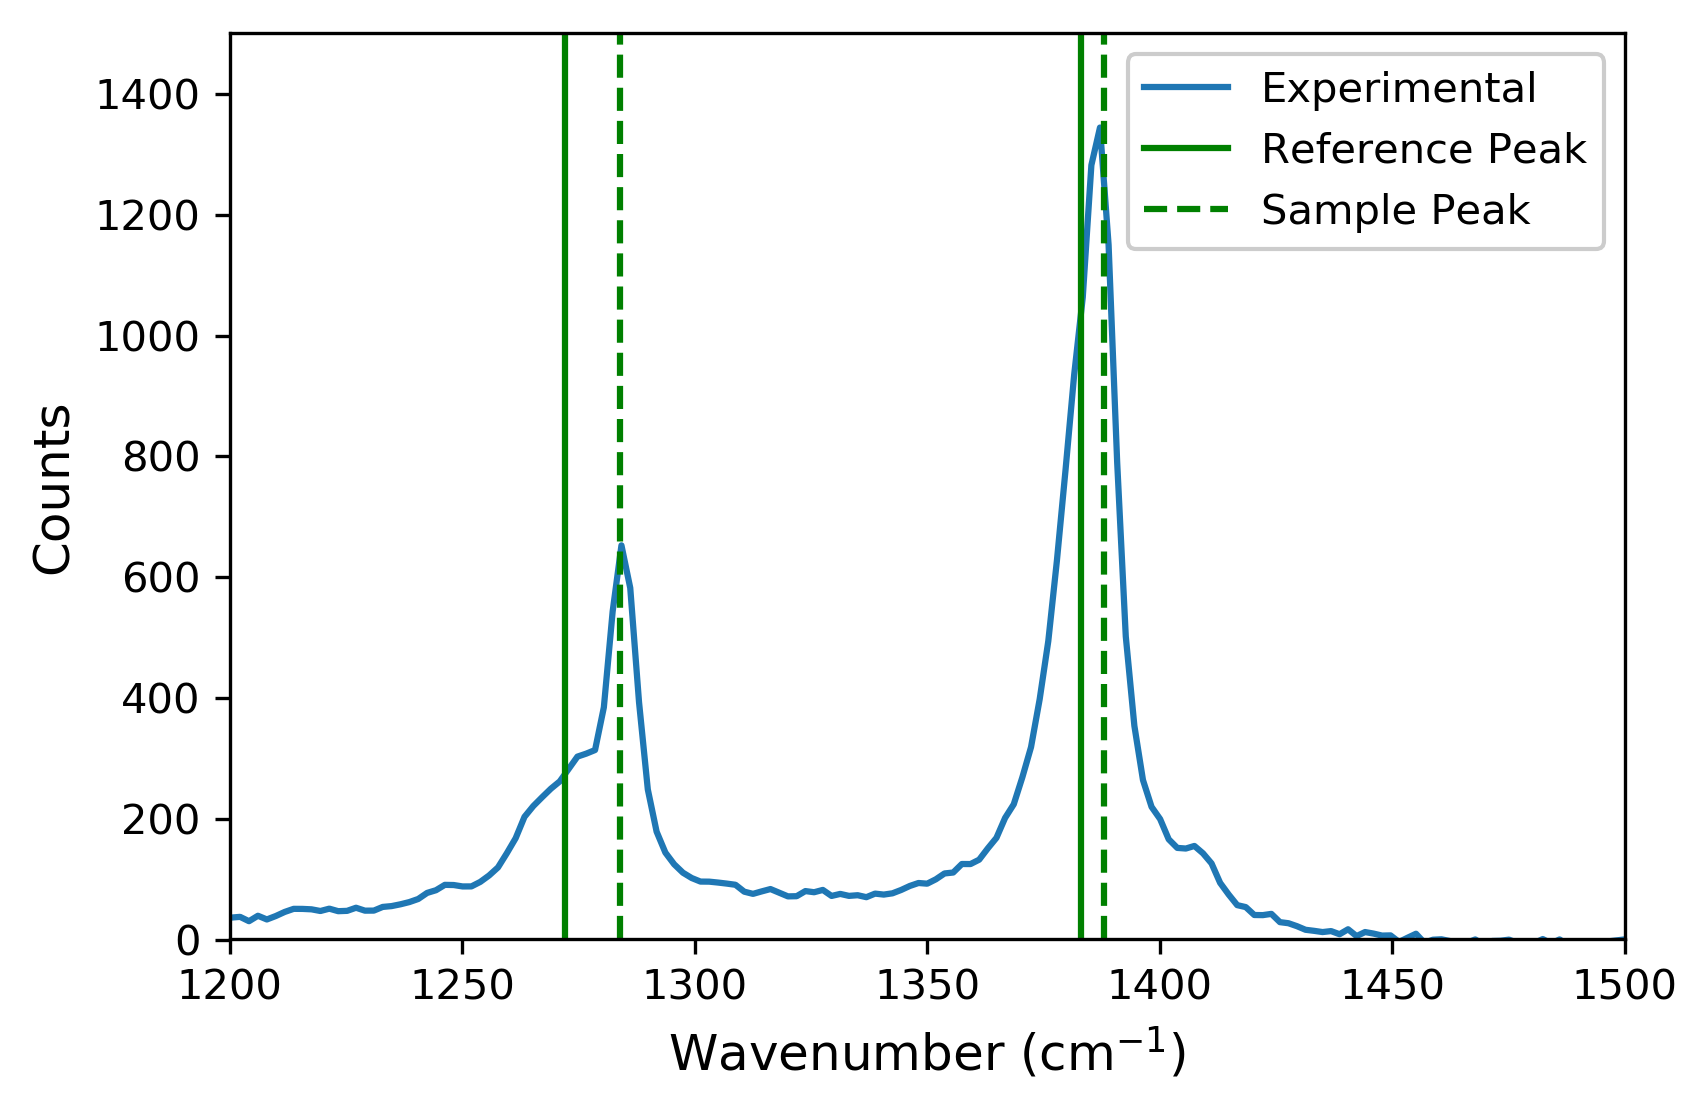

In [34]:
fig = plt.figure(figsize=(6,4), dpi = 300)
plt.plot(x_data, y_data, label ='Experimental')
#plt.plot(H2O_CO2_x, H2O_CO2_y, color = 'red', label = 'Sample Spectra')
plt.xlabel('cm$^{-1}$', fontsize=14)
plt.ylabel('Absoprtion', fontsize=14)
plt.axvline(x = Exp_peaks[9], color = 'green', label='Reference Peak')
plt.axvline(x = Exp_peaks[9]+12, color = 'green', linestyle='--', label='Sample Peak')
plt.axvline(x = Exp_peaks[10], color = 'green')
plt.axvline(x = Exp_peaks[10]+5, color = 'green', linestyle='--')
# plt.axvline(x = H2O_CO2_peaks[5], color = 'red', label='CO2 Reference Peak')
# plt.axvline(x = H2O_CO2_peaks[6], color = 'red')
plt.xlabel('Wavenumber (cm$^{-1}$)', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.ylim(0.2,1500)
plt.xlim(1200, 1500)
plt.legend(loc=1, framealpha=1)
#plt.savefig('CO2_Confidence_Interval_plot.png')

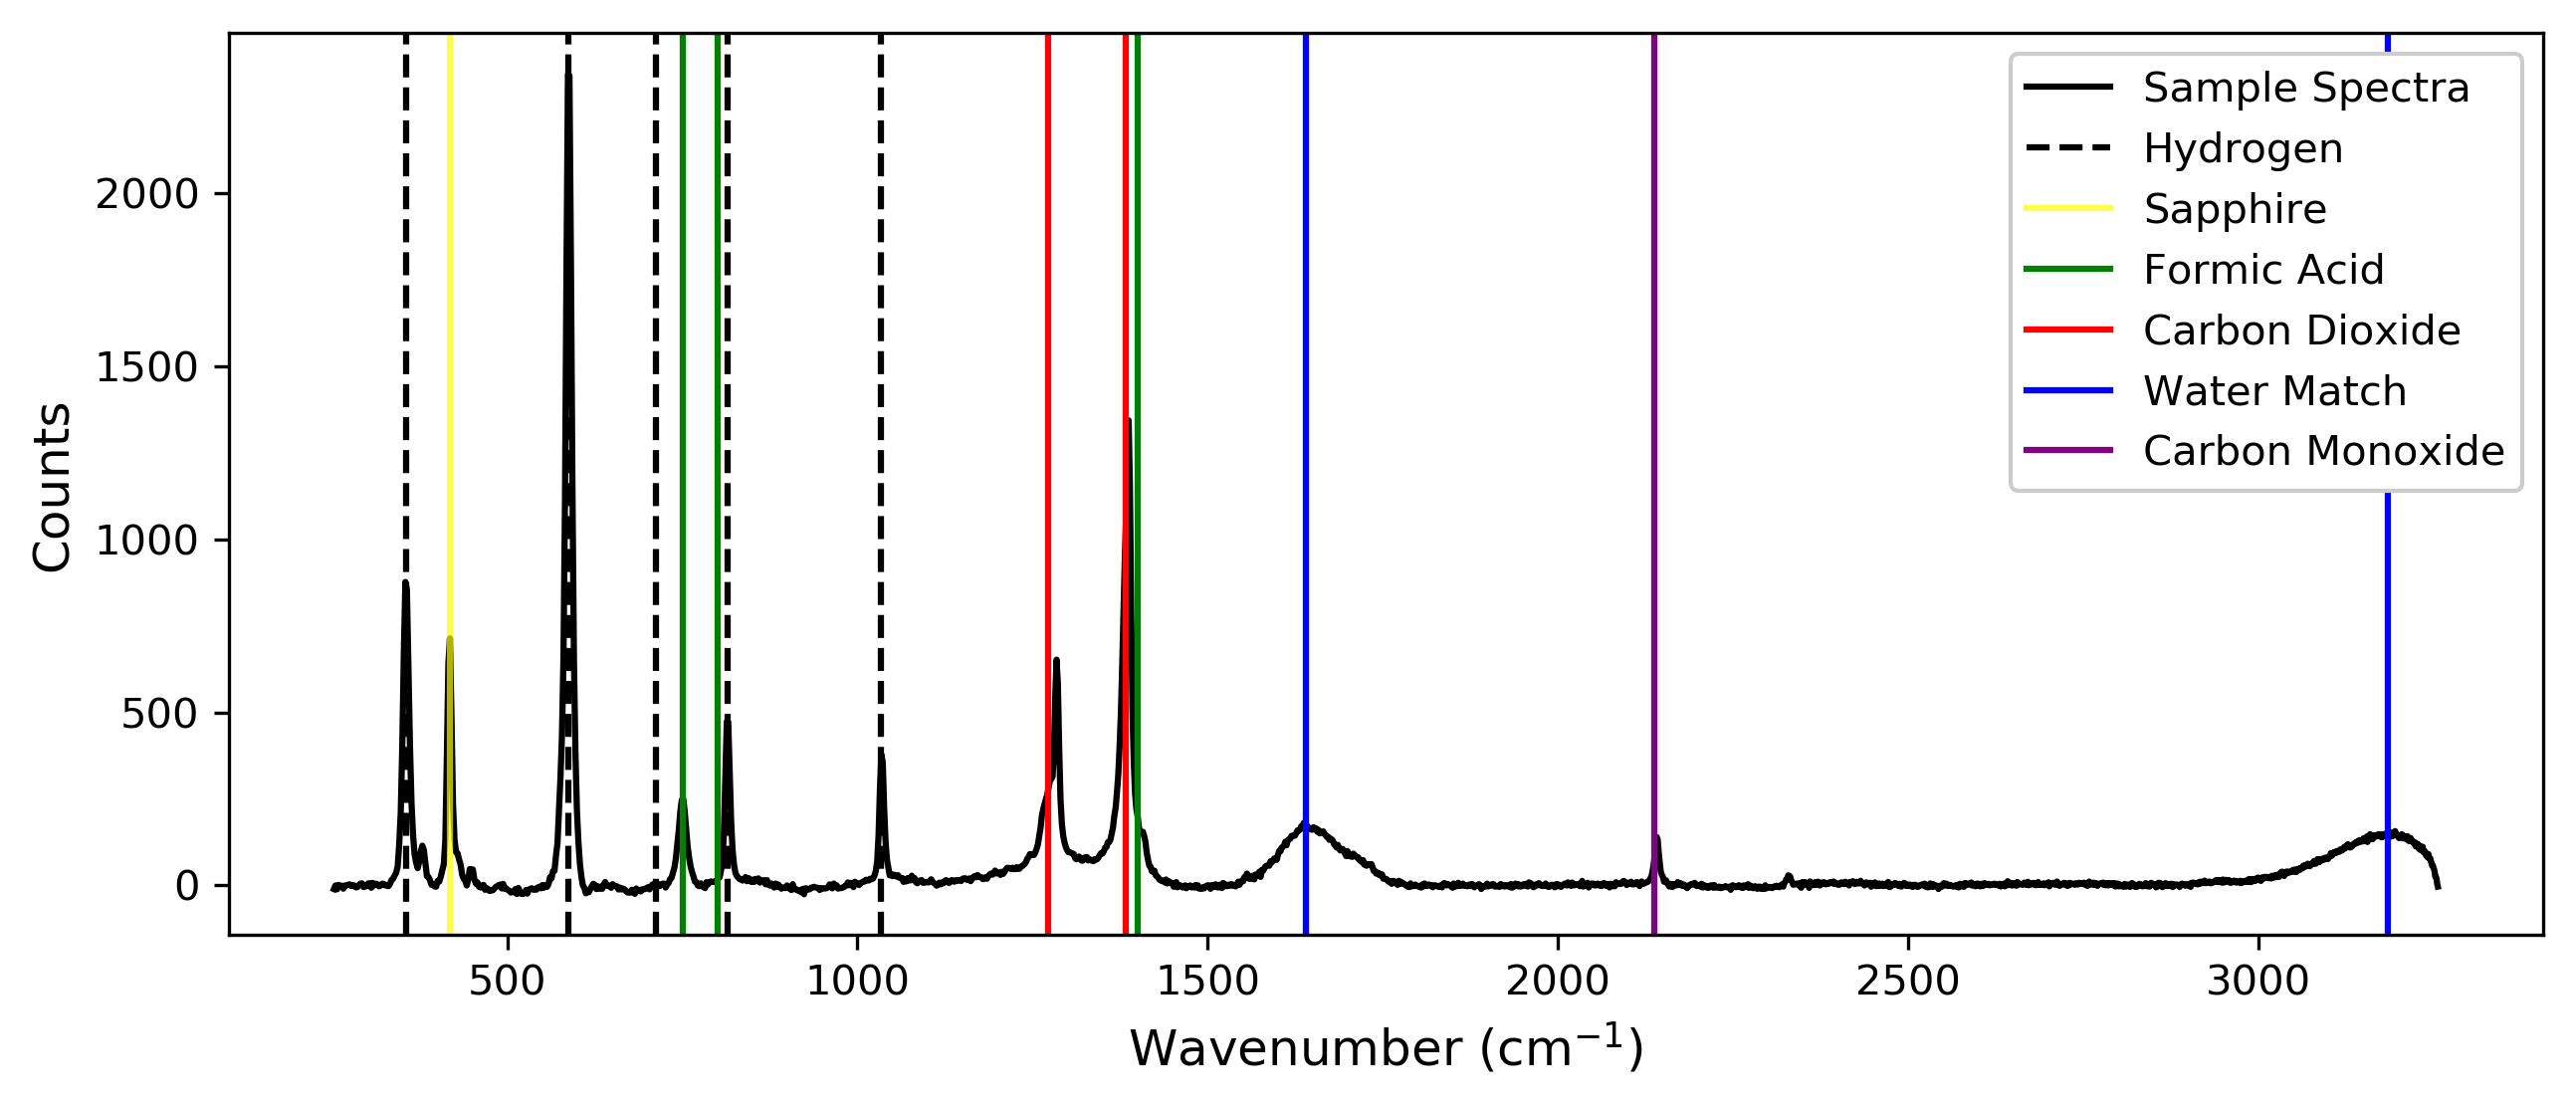

In [37]:
#Ok, now that we have which peaks belong to which component, we'll need to plot their position.
fig = plt.figure(figsize=(10,4), dpi = 300)
plt.plot(x_data, y_data, color = 'black', label = 'Sample Spectra')
plt.axvline(x = Exp_peaks[0], color = 'black', label = 'Hydrogen',linestyle='--')
#plt.axvline(x = Exp_peaks[1], color = 'yellow',alpha=.7)
plt.axvline(x = Exp_peaks[2], color = 'yellow', label = 'Sapphire',alpha=.7)
plt.axvline(x = Exp_peaks[3], color = 'black', linestyle='--')
plt.axvline(x = Exp_peaks[4], color = 'black', linestyle='--')
plt.axvline(x = Exp_peaks[5], color = 'green', label = 'Formic Acid')
plt.axvline(x = Exp_peaks[5]+50, color = 'green')
plt.axvline(x = Exp_peaks[6], color = 'black', linestyle='--')
plt.axvline(x = Exp_peaks[7], color = 'black', linestyle='--')
#plt.axvline(x = Exp_peaks[8], color = 'green')
plt.axvline(x = Exp_peaks[9], color = 'red', label = 'Carbon Dioxide')
plt.axvline(x = Exp_peaks[10], color = 'red')
plt.axvline(x = Exp_peaks[11], color = 'green')
plt.axvline(x = Exp_peaks[12], color = 'blue',label = 'Water Match')
plt.axvline(x = Exp_peaks[13], color = 'purple', label = 'Carbon Monoxide')
#plt.axvline(x = Exp_peaks[14], color = 'green')
plt.axvline(x = Exp_peaks[15], color = 'blue')
plt.legend(loc=1, framealpha=1)
plt.xlabel('Wavenumber (cm$^{-1}$)', fontsize=12)
plt.ylabel('Counts', fontsize=12)
#plt.ylim(-0.1, 1.3)
# plt.ylim()
    
#     plt.axvline(x=H2O_CO_x[i], color='orange')
plt.savefig('Experimental_In_situ_Reference.png')